In [2]:
!pip install transformers datasets tweet-preprocessor ray[tune] hyperopt

     |████████████████████████████████| 1.4MB 16.4MB/s 
     |████████████████████████████████| 163kB 45.4MB/s 
     |████████████████████████████████| 23.1MB 59.0MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
     |████████████████████████████████| 2.9MB 43.2MB/s 
     |████████████████████████████████| 17.7MB 218kB/s 
     |████████████████████████████████| 245kB 51.4MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 204kB 63.7MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 2.9MB 44.7MB/s 
     |████████████████████████████████| 133kB 58.2MB/s 
     |████████████████████████████████| 1.3MB 43.6MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 317kB 50.9MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 296kB 53.4MB/s 
     |████████████████████████████████| 143kB 50.5MB

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns
import torch

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.special import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
# dataset_dem = pd.read_csv('/content/drive/MyDrive/democrat_tweets_v2.csv')
# dataset_gop = pd.read_csv('/content/drive/MyDrive/republican_tweets_v2.csv')

# dataset_dem["label"] = "Democrat"
# dataset_gop["label"] = "Republican"

# dataset_final = pd.concat([dataset_dem, dataset_gop])
# dataset_final.reset_index(drop=True, inplace=True)
dataset_final = pd.read_csv("/content/drive/MyDrive/Copy of 2020_labled_political_tweets.csv.zip")
dataset_final = dataset_final.iloc[0:50000]
for index, row in dataset_final.iterrows():
    if str(row['party']) !="D":
      if str(row["party"])!="R":
        dataset_final.drop(index, inplace=True)
dataset_final.head()

,Unnamed: 0,id,screen_name,user_id,time,link,text,source,party
0,1,1212432932746473472,RepLoriTrahan,1079802482640019456,2020-01-01T12:58:31-05:00,https://www.twitter.com/RepLoriTrahan/statuses...,I am proud of the work we’ve done over the pas...,Twitter for iPhone,D
1,2,1212390455729696768,RepDwightEvans,90639372,2020-01-01T10:09:44-05:00,https://www.twitter.com/RepDwightEvans/statuse...,2/ @MorethanmySLE – a cancer survivor and lupu...,Twitter for iPhone,D
2,3,1212250054788038656,RepThomasMassie,975200486,2020-01-01T00:51:50-05:00,https://www.twitter.com/RepThomasMassie/status...,"@ceQs17 Why are our people in Iraq, and how di...",Twitter for iPhone,R
3,4,1212500813593169920,SenCoryGardner,235217558,2020-01-01T17:28:15-05:00,https://www.twitter.com/SenCoryGardner/statuse...,@EnergyGOP @BLMNational @SenatorBennet @Senate...,Twitter Web App,R
4,6,1212239323392856064,RepGraceMeng,1051127714,2020-01-01T00:09:11-05:00,https://www.twitter.com/RepGraceMeng/statuses/...,"It’s 2020! As we enter a new decade, I wish ev...",Twitter for iPhone,D


In [38]:
LABEL_MAP = {
    "D": 0,
    "R": 1
}

def buildLabels(row):
    return LABEL_MAP.get(row["party"])


def cleanTweet(row):
  tweet = row["text"]
  tweet = str(p.clean(tweet))
  tweet = re.sub(r'[^\w\s]', '', tweet) # punctuation
  tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet) # numbers
  return tweet

  
dataset_final["party"] = dataset_final.apply(lambda row: buildLabels(row), axis=1)
dataset_final["clean_text"] = dataset_final.apply(lambda row: cleanTweet(row), 
                                                  axis=1)

In [39]:
dataset_clf = dataset_final[["clean_text", "party"]]
dataset_clf.reset_index(drop=True, inplace=True)
dataset_clf.head()

,clean_text,party
0,I am proud of the work weve done over the past...,0
1,a cancer survivor and lupus warrior spoke wi...,0
2,Why are our people in Iraq and how did Iran co...,1
3,This year the first ever statelevel measuremen...,1
4,Its As we enter a new decade I wish everybody...,0


In [7]:
X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                  dataset_clf.party.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_clf.party.values)

dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_clf.loc[X_train, 'data_type'] = 'train'
dataset_clf.loc[X_val, 'data_type'] = 'test'

dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
def get_dataloaders(data, batch_size):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                            do_lower_case=True)
  # tokenize train and test data so BERT can understand it
  encoded_data_train = tokenizer.batch_encode_plus(
      data[data.data_type=='train'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True,
      max_length=64, 
      return_tensors='pt'
  )

  encoded_data_test = tokenizer.batch_encode_plus(
      data[data.data_type=='test'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True, 
      max_length=64, 
      return_tensors='pt'
  )


  # destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(data[data.data_type=='train'].party.values)

  input_ids_test = encoded_data_test['input_ids']
  attention_masks_test = encoded_data_test['attention_mask']
  labels_test = torch.tensor(data[data.data_type=='test'].party.values)

  train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

  train_dataloader = DataLoader(train_data, 
                                sampler=RandomSampler(train_data), 
                                batch_size=batch_size)

  test_dataloader = DataLoader(test_data,
                              sampler=SequentialSampler(test_data),
                              batch_size=batch_size)
  
  return train_dataloader, test_dataloader

In [9]:
def auc_score(preds, labels):
  soft_preds = softmax(preds, axis=1) # logit -> probability
  if np.shape(preds)[1] > 2: # check for multi-class
    return roc_auc_score(labels, soft_preds, multi_class='ovr')
  else:
    soft_preds = soft_preds[:,1]
    return roc_auc_score(labels, soft_preds)

def acc_score_by_class(preds, labels):
  label_dict_inverse = {v: k for k, v in LABEL_MAP.items()} 

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [10]:
def evaluate(model, dataloader, device):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader:
      
      # convert data to CUDA
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {
          'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
      }

      with torch.no_grad():        
          outputs = model(**inputs) # get predictions
          
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return loss_val_avg, predictions, true_vals

In [11]:
def train_and_hyperparam_search(config,
                                model_init, # function to init a clean version of the net
                                data,       # data as Pandas array
                                cv          # rounds of cross-validation
                                ):
  losses = []
  aucs = []
  skf = StratifiedKFold(n_splits=cv, shuffle=True)
  for train_idx, test_idx in skf.split(data.clean_text, data.party):
    model = model_init()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Device: {device}")

    optimizer = AdamW(model.parameters(),
                    lr=config['lr'],
                    eps=1e-8) # keep this the same, just prevents exploding gradients
    
    data.loc[train_idx, 'data_type'] = 'train'
    data.loc[test_idx, 'data_type'] = 'test'
    
    train_dataloader, test_dataloader = get_dataloaders(data,
                                                        config['batch_size'])

    for epoch in range(1, config['epochs']+1):
      model.train() # enter training mode
      loss_train_total = 0

      for batch in train_dataloader:
          model.zero_grad()
          
          # get CUDA data
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {
              'input_ids':      batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2],
          }

          outputs = model(**inputs) # evaluate
          
          # for reference, we are using cross-entropy loss here,
          # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward() # do backprop

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
              
      
      loss_train_avg = loss_train_total/len(train_dataloader)    
      print(f"Training loss for epoch {epoch}: {loss_train_avg}")        
      
      val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
      auc = auc_score(predictions, true_vals)

      losses.append(val_loss)
      aucs.append(auc)

  tune.report(loss=np.mean(losses), auc=np.mean(aucs))

In [12]:
from functools import partial

def model_init():
   return BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                        num_labels=2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)   

   
config = {
    "lr": tune.choice([5e-5, 3e-5, 1e-5, 2e-5]),
    "batch_size": tune.choice([8, 16, 32]),
    "epochs": tune.choice([2, 3, 4])
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(metric_columns=["loss", "auc", "training_iteration"])
hyperopt_search = HyperOptSearch(metric="loss", mode="min")

result = tune.run(
    partial(train_and_hyperparam_search, model_init=model_init, data=dataset_clf, cv=3),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=8,
    scheduler=scheduler,
    search_alg=hyperopt_search,
    progress_reporter=reporter
)

2020-12-09 13:21:39,966	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-09 13:21:42,558	WARNING experiment.py:274 -- No name detected on trainable. Using DEFAULT.
2020-12-09 13:21:42,561	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.
2020-12-09 13:21:42,563	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-09_13-21-42
Number of trials: 1/8 (1 RUNNING)
+------------------+----------+-------+--------------+----------+-------+
| Trial name       | status   | loc   |   batch_size |   epochs |    lr |
|------------------+----------+-------+--------------+----------+-------|
| DEFAULT_7a6857be | RUNNING  |       |            8 |        3 | 2e-05 |
+------------------+----------+-------+--------------+----------+-------+




(pid=385) 2020-12-09 13:21:44.136804: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Downloading: 100%|██████████| 433/433 [00:00<00:00, 575kB/s]
Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]
Downloading:   2%|▏         | 8.71M/440M [00:00<00:04, 87.1MB/s]
Downloading:   4%|▍         | 17.8M/440M [00:00<00:04, 88.2MB/s]
Downloading:   6%|▌         | 26.7M/440M [00:00<00:04, 88.5MB/s]
Downloading:   8%|▊         | 36.0M/440M [00:00<00:04, 89.8MB/s]
Downloading:  10%|█         | 45.1M/440M [00:00<00:04, 90.1MB/s]
Downloading:  12%|█▏        | 54.6M/440M [00:00<00:04, 91.6MB/s]
Downloading:  14%|█▍        | 63.4M/440M [00:00<00:04, 90.4MB/s]
Downloading:  17%|█▋        | 72.7M/440M [00:00<00:04, 91.2MB/s]
Downloading:  18%|█▊        | 81.4M/440M [00:00<00:04, 89.6MB/s]
Downloading:  21%|██        | 90.9M/440M [00:01<00:03, 91.1MB/s]
Downloading:  23%|██▎       | 100M/440M [00:01<00:03, 92.2MB/s] 
Downloading:

(pid=385) Device: cuda


Downloading: 100%|██████████| 232k/232k [00:00<00:00, 20.2MB/s]


(pid=385) Training loss for epoch 1: 0.6163573170053787
(pid=385) Training loss for epoch 2: 0.39854388329051976
(pid=385) Training loss for epoch 3: 0.22814156145114983


(pid=385) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=385) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=385) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=385) Some weights of BertForSequenceClassification were not 

(pid=385) Device: cuda
(pid=385) Training loss for epoch 1: 0.593745406087182
(pid=385) Training loss for epoch 2: 0.38976584565218375
(pid=385) Training loss for epoch 3: 0.24735796834023868


(pid=385) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=385) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=385) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=385) Some weights of BertForSequenceClassification were not 

(pid=385) Device: cuda
(pid=385) Training loss for epoch 1: 0.6241101933202305
(pid=385) Training loss for epoch 2: 0.41037320737065613
(pid=385) Training loss for epoch 3: 0.2530334459053654
Result for DEFAULT_7a6857be:
  auc: 0.8521918671231413
  date: 2020-12-09_13-42-07
  done: false
  experiment_id: fb6ee07b395a4effb8f64b8430ea911e
  experiment_tag: 1_batch_size=8,epochs=3,lr=2e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.6217632158947156
  node_ip: 172.28.0.2
  pid: 385
  time_since_restore: 1221.8476831912994
  time_this_iter_s: 1221.8476831912994
  time_total_s: 1221.8476831912994
  timestamp: 1607521327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a6857be
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6217632158947156
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 acce

(pid=386) 2020-12-09 13:42:08.637930: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=386) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=386) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=386) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initi

(pid=386) Device: cuda
(pid=386) Training loss for epoch 1: 0.628031745625003
(pid=386) Training loss for epoch 2: 0.37869058430626773


(pid=386) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=386) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=386) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=386) Some weights of BertForSequenceClassification were not 

(pid=386) Device: cuda
(pid=386) Training loss for epoch 1: 0.6181302302413516
(pid=386) Training loss for epoch 2: 0.3897272947689761


(pid=386) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=386) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=386) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=386) Some weights of BertForSequenceClassification were not 

(pid=386) Device: cuda
(pid=386) Training loss for epoch 1: 0.659524104733398
(pid=386) Training loss for epoch 2: 0.4744058852466408
Result for DEFAULT_7a9c0bc2:
  auc: 0.8336465855755205
  date: 2020-12-09_13-55-02
  done: false
  experiment_id: d95e3c48ac434ebba4a16a751d17fb6c
  experiment_tag: 2_batch_size=16,epochs=2,lr=5e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.5095848584643158
  node_ip: 172.28.0.2
  pid: 386
  time_since_restore: 772.5341606140137
  time_this_iter_s: 772.5341606140137
  time_total_s: 772.5341606140137
  timestamp: 1607522102
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a9c0bc2
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5656740371795157
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_20

(pid=956) 2020-12-09 13:55:04.243490: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=956) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=956) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=956) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initi

(pid=956) Device: cuda
(pid=956) Training loss for epoch 1: 0.6095581750075022
(pid=956) Training loss for epoch 2: 0.3905989213842125
(pid=956) Training loss for epoch 3: 0.2093590086074051


(pid=956) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=956) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=956) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=956) Some weights of BertForSequenceClassification were not 

(pid=956) Device: cuda
(pid=956) Training loss for epoch 1: 0.5988135712158277
(pid=956) Training loss for epoch 2: 0.372393103685356
(pid=956) Training loss for epoch 3: 0.2120149424524555


(pid=956) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=956) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=956) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=956) Some weights of BertForSequenceClassification were not 

(pid=956) Device: cuda
(pid=956) Training loss for epoch 1: 0.6684979554535686
(pid=956) Training loss for epoch 2: 0.5363291733794742
(pid=956) Training loss for epoch 3: 0.3439416029639002
Result for DEFAULT_546b667a:
  auc: 0.8373084335657307
  date: 2020-12-09_14-14-04
  done: true
  experiment_id: 7ca774b1b6ec4636ba23dfe18d02a513
  experiment_tag: 3_batch_size=16,epochs=3,lr=5e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.5671508503624071
  node_ip: 172.28.0.2
  pid: 956
  time_since_restore: 1138.8799440860748
  time_this_iter_s: 1138.8799440860748
  time_total_s: 1138.8799440860748
  timestamp: 1607523244
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 546b667a
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5671508503624071
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accel

(pid=1245) 2020-12-09 14:14:06.425913: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1245) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1245) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1245) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1245) Device: cuda
(pid=1245) Training loss for epoch 1: 0.6415765521606961
(pid=1245) Training loss for epoch 2: 0.4735718579683903


(pid=1245) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1245) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1245) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1245) Some weights of BertForSequenceClassification were 

(pid=1245) Device: cuda
(pid=1245) Training loss for epoch 1: 0.6214637574942216
(pid=1245) Training loss for epoch 2: 0.39616632321174594


(pid=1245) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1245) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1245) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1245) Some weights of BertForSequenceClassification were 

(pid=1245) Device: cuda
(pid=1245) Training loss for epoch 1: 0.5983448253161665
(pid=1245) Training loss for epoch 2: 0.3934670258043469
Result for DEFAULT_2279ad46:
  auc: 0.8374665157065424
  date: 2020-12-09_14-26-12
  done: false
  experiment_id: c1cada43388143669b4e910df304f761
  experiment_tag: 4_batch_size=16,epochs=2,lr=2e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.5023385261734709
  node_ip: 172.28.0.2
  pid: 1245
  time_since_restore: 724.2906517982483
  time_this_iter_s: 724.2906517982483
  time_total_s: 724.2906517982483
  timestamp: 1607523972
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2279ad46
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5383678544133614
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAU

(pid=1443) 2020-12-09 14:26:13.807092: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1443) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1443) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1443) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1443) Device: cuda
(pid=1443) Training loss for epoch 1: 0.6545116924322568
(pid=1443) Training loss for epoch 2: 0.541412851271721
(pid=1443) Training loss for epoch 3: 0.40880019318025845


(pid=1443) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1443) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1443) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1443) Some weights of BertForSequenceClassification were 

(pid=1443) Device: cuda
(pid=1443) Training loss for epoch 1: 0.6429526341649202
(pid=1443) Training loss for epoch 2: 0.5364512838423252
(pid=1443) Training loss for epoch 3: 0.4228514342640455


(pid=1443) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1443) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1443) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1443) Some weights of BertForSequenceClassification were 

(pid=1443) Device: cuda
(pid=1443) Training loss for epoch 1: 0.6684460903589542
(pid=1443) Training loss for epoch 2: 0.5912256679282739
(pid=1443) Training loss for epoch 3: 0.45878010988235474
Result for DEFAULT_cb1e259c:
  auc: 0.7734920045381223
  date: 2020-12-09_14-43-11
  done: true
  experiment_id: 8aea6115b58f4d48be668ca6be246c40
  experiment_tag: 5_batch_size=32,epochs=3,lr=1e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.5669525369492353
  node_ip: 172.28.0.2
  pid: 1443
  time_since_restore: 1016.6535909175873
  time_this_iter_s: 1016.6535909175873
  time_total_s: 1016.6535909175873
  timestamp: 1607524991
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: cb1e259c
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5669525369492353
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0

(pid=1704) 2020-12-09 14:43:13.814070: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=1704) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1704) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1704) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=1704) Device: cuda
(pid=1704) Training loss for epoch 1: 0.5972731544631691
(pid=1704) Training loss for epoch 2: 0.3616375879717514
(pid=1704) Training loss for epoch 3: 0.2361250184524179


(pid=1704) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1704) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1704) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1704) Some weights of BertForSequenceClassification were 

(pid=1704) Device: cuda
(pid=1704) Training loss for epoch 1: 0.6147056800011851
(pid=1704) Training loss for epoch 2: 0.37516995999908104
(pid=1704) Training loss for epoch 3: 0.215471639279906


(pid=1704) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=1704) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1704) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1704) Some weights of BertForSequenceClassification were 

(pid=1704) Device: cuda
(pid=1704) Training loss for epoch 1: 0.6088660380258653
(pid=1704) Training loss for epoch 2: 0.4005644327650468
(pid=1704) Training loss for epoch 3: 0.24858389553728688
Result for DEFAULT_7ccd1c2a:
  auc: 0.8536271697605836
  date: 2020-12-09_15-03-26
  done: true
  experiment_id: 29796f546e6748ba84c0c9e262897ac1
  experiment_tag: 6_batch_size=8,epochs=3,lr=2e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.6260140958256866
  node_ip: 172.28.0.2
  pid: 1704
  time_since_restore: 1211.056120634079
  time_this_iter_s: 1211.056120634079
  time_total_s: 1211.056120634079
  timestamp: 1607526206
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7ccd1c2a
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5670516936558212
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 acc

(pid=2010) 2020-12-09 15:03:28.246263: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=2010) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=2010) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2010) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=2010) Device: cuda
(pid=2010) Training loss for epoch 1: 0.6460603684760057
(pid=2010) Training loss for epoch 2: 0.47896013065026355


(pid=2010) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=2010) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2010) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2010) Some weights of BertForSequenceClassification were 

(pid=2010) Device: cuda
(pid=2010) Training loss for epoch 1: 0.6540391760376784
(pid=2010) Training loss for epoch 2: 0.485520909468715


(pid=2010) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=2010) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2010) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2010) Some weights of BertForSequenceClassification were 

(pid=2010) Device: cuda
(pid=2010) Training loss for epoch 1: 0.6479547482270461
(pid=2010) Training loss for epoch 2: 0.485783673536319
Result for DEFAULT_dc9d146e:
  auc: 0.8043738499524257
  date: 2020-12-09_15-15-21
  done: false
  experiment_id: f902f36b61a24301be7ae8072d133b1c
  experiment_tag: 7_batch_size=32,epochs=2,lr=2e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.5383306954247065
  node_ip: 172.28.0.2
  pid: 2010
  time_since_restore: 711.7953827381134
  time_this_iter_s: 711.7953827381134
  time_total_s: 711.7953827381134
  timestamp: 1607526921
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc9d146e
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5669525369492353
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAUL

(pid=2202) 2020-12-09 15:15:23.432127: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=2202) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=2202) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2202) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=2202) Device: cuda
(pid=2202) Training loss for epoch 1: 0.6262942112010458
(pid=2202) Training loss for epoch 2: 0.4132556789307203
(pid=2202) Training loss for epoch 3: 0.20980357792642382
(pid=2202) Training loss for epoch 4: 0.11168810254320556


(pid=2202) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=2202) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2202) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2202) Some weights of BertForSequenceClassification were 

(pid=2202) Device: cuda
(pid=2202) Training loss for epoch 1: 0.6270090186077616
(pid=2202) Training loss for epoch 2: 0.43519194222590774
(pid=2202) Training loss for epoch 3: 0.23721409940885174
(pid=2202) Training loss for epoch 4: 0.14021248878249765


(pid=2202) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=2202) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2202) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=2202) Some weights of BertForSequenceClassification were 

(pid=2202) Device: cuda
(pid=2202) Training loss for epoch 1: 0.6467352192758938
(pid=2202) Training loss for epoch 2: 0.4376493170497498
(pid=2202) Training loss for epoch 3: 0.23466223894038063
(pid=2202) Training loss for epoch 4: 0.13098298916863144


2020-12-09 15:40:43,870	INFO tune.py:439 -- Total run time: 8344.54 seconds (8341.16 seconds for the tuning loop).


Result for DEFAULT_b07de798:
  auc: 0.8488854335460952
  date: 2020-12-09_15-40-43
  done: true
  experiment_id: 1f7eb988a8894b42bfbbfa6b347ce9de
  experiment_tag: 8_batch_size=16,epochs=4,lr=2e-05
  hostname: dfae92d5365f
  iterations_since_restore: 1
  loss: 0.647390975222105
  node_ip: 172.28.0.2
  pid: 2202
  time_since_restore: 1518.9703786373138
  time_this_iter_s: 1518.9703786373138
  time_total_s: 1518.9703786373138
  timestamp: 1607528443
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b07de798
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.5670516936558212
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-09_13-21-42
Number of trials: 8/8 (8 TERMINATED)
+------------------+------------+-------+--------------+----------+-------+--

Text(0, 0.5, 'Score')

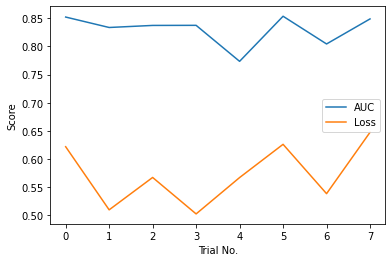

In [13]:
dfs = result.fetch_trial_dataframes()

aucs = []
losses = []
for d in dfs.values():
  aucs.append(d.auc)
  losses.append(d.loss)

plt.plot(range(0, 8), aucs, label="AUC")
plt.plot(range(0, 8), losses, label="Loss")
plt.legend()
plt.xlabel("Trial No.")
plt.ylabel("Score")


best candidates appear to come from trials with batch 8 epoch 3, and batch 16 epoch 4

In [12]:
def train(model, epochs, train_dataloader, test_dataloader, optimizer, scheduler):
  for epoch in tqdm(range(1, epochs+1)): # use tqdm for a progress bar
    model.train() # enter training mode
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        
        # get CUDA data
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }

        outputs = model(**inputs) # evaluate
        
        # for reference, we are using cross-entropy loss here,
        # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # do backprop

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
    auc = auc_score(predictions, true_vals)
    tqdm.write(f'Testing loss: {val_loss}')
    tqdm.write(f'AUC: {auc}')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [25]:
def new_train_test_split(dataset_clf):
  X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                    dataset_clf.party.values, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=dataset_clf.party.values)

  dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

  dataset_clf.loc[X_train, 'data_type'] = 'train'
  dataset_clf.loc[X_val, 'data_type'] = 'test'

  # dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
  # dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

In [40]:
new_train_test_split(dataset_clf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [29]:
# trial 2 for 10k
# |  batch_size |   epochs |          lr |
#            16 |        4 | 2e-05

import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 3
BATCH_SIZE = 16
lr = 2e-5


train_dataloader, test_dataloader = get_dataloaders(dataset_clf, BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                    num_labels=2,
                                                    output_attentions=False,
                                                    output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*EPOCHS)
model.to(device)

train(model, EPOCHS, train_dataloader, test_dataloader, optimizer, scheduler)
test_loss, preds, labels = evaluate(model, test_dataloader, device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.5386573755266991
Testing loss: 0.4175835700428232
AUC: 0.8906339576869973



Epoch 2
Training loss: 0.31054414546992065
Testing loss: 0.39128657089585955
AUC: 0.9175344389941767



Epoch 3
Training loss: 0.16890854493513788
Testing loss: 0.4912815410049355
AUC: 0.9160394557597409



Accuracy: 0.7879194630872484
AUC Score: 0.8797161097728583
Test loss: 0.6821598135965302


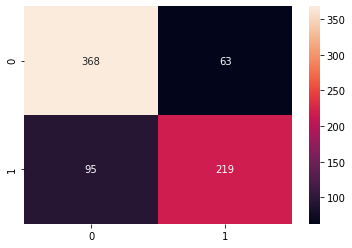

In [19]:
print(f"Accuracy: {accuracy_score(labels, np.argmax(preds, axis=1))}")
print(f"AUC Score: {auc_score(preds, labels)}")
print(f"Test loss: {test_loss}")
sns.heatmap(confusion_matrix(labels, np.argmax(preds, axis=1)), annot=True, fmt="d")

In [41]:
# trial 1 for 50k
# |  batch_size |   epochs |          lr |
# |           8 |        3 | 2e-05 |
# Ran with epoch 3 and gave a worse auc/loss/accuracy, so running it with epoch 2
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 3
BATCH_SIZE = 8
lr = 2e-5


train_dataloader, test_dataloader = get_dataloaders(dataset_clf, BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                    num_labels=2,
                                                    output_attentions=False,
                                                    output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*EPOCHS)
model.to(device)

train(model, EPOCHS, train_dataloader, test_dataloader, optimizer, scheduler)
test_loss, preds, labels = evaluate(model, test_dataloader, device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.4298693675768582
Testing loss: 0.38231699006999703
AUC: 0.9282495508488825



Epoch 2
Training loss: 0.2719934223457612
Testing loss: 0.4718398309407442
AUC: 0.9375457915501538



Epoch 3
Training loss: 0.1500415800407391
Testing loss: 0.660488260722317
AUC: 0.938660206530352



Accuracy: 0.8696819218896792
AUC Score: 0.938660206530352
Test loss: 0.660488260722317


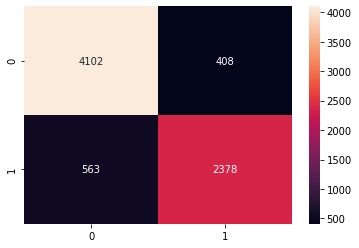

In [43]:
print(f"Accuracy: {accuracy_score(labels, np.argmax(preds, axis=1))}")
print(f"AUC Score: {auc_score(preds, labels)}")
print(f"Test loss: {test_loss}")
sns.heatmap(confusion_matrix(labels, np.argmax(preds, axis=1)), annot=True, fmt="d")

In [44]:
torch.save(model,"/content/drive/MyDrive/50k_tweets_model.model")

Trial # 1 seemed to go better (at least on the train-test split we evaluated both models on). Therefore, we will pick that trial as our winner and have the following hyperparameters:

- Batch Size: 16
- Epochs: 2
- Learning rate: 2e-5

In [30]:
# trial 3 for 10k
# |  batch_size |   epochs |          lr |
# |           4 |        3 | 2e-05 |
# Ran with epoch 3 and gave a worse auc/loss/accuracy, so running it with epoch 2
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 3
BATCH_SIZE = 4
lr = 2e-5


train_dataloader, test_dataloader = get_dataloaders(dataset_clf, BATCH_SIZE)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                    num_labels=2,
                                                    output_attentions=False,
                                                    output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*EPOCHS)
model.to(device)

train(model, EPOCHS, train_dataloader, test_dataloader, optimizer, scheduler)
test_loss, preds, labels = evaluate(model, test_dataloader, device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1
Training loss: 0.5460656700404228
Testing loss: 0.4521691040198341
AUC: 0.9051966796993812



Epoch 2
Training loss: 0.379504987029127
Testing loss: 0.644182944117893
AUC: 0.9151297464796001



Epoch 3
Training loss: 0.17771465573868833
Testing loss: 0.9104426930458069
AUC: 0.9161214862824689



In [7]:
model50 = torch.load("/content/drive/MyDrive/Copy of 50k_tweets_model.model")

In [9]:
torch.save(model50.state_dict(),"/content/drive/MyDrive/new_50k_tweets_model.model")